In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AgglomerativeClustering, KMeans
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.metrics import silhouette_score, confusion_matrix
import math

pd.set_option('display.float_format', '{:.5f}'.format)
%matplotlib inline

In [2]:
df = pd.read_csv('breast_cancer.csv')
initial_list = df.columns.tolist()
updated = [each.lower().replace(' ', '_') for each in initial_list]
rename_dict = {initial_list[i]: updated[i] for i in range(len(initial_list))}
df.rename(columns=rename_dict, inplace=True)

df_sub = df[['clump_thickness',
             'cell_size',
             'cell_shape',
             'marginal_adhesion',
             'single_epithelial_cell_size',
             'bare_nuclei',
             'bland_chromatin',
             'normal_nucleoli',
             'mitoses']]

data_bc_gt_label = df['class'].to_numpy()

#Breast Cancer Data 
num_feat_bc = df_sub.shape[1]
data_bc = df_sub.to_numpy()
num_points_bc = len(data_bc)

In [3]:
def kmeans_cluster_func(n_clusters=None, data=None):
    n_clusters = n_clusters
    km = KMeans(n_clusters = n_clusters, random_state=42).fit(data)
    
    point_dict = {each+1: data[np.where(km.predict(data) == each)[0]] for each in range(km.n_clusters)}
    centroid_points = {idx+1: each for idx, each in enumerate(km.cluster_centers_)}
    
    return centroid_points, point_dict

def error_function(n_clusters=None, data=None):
    data_n_clusters = kmeans_cluster_func(n_clusters=n_clusters, data=data)
    dict_data_centroids = data_n_clusters[0]
    dict_data_points = data_n_clusters[1]

    sum_data_points = []

    for idx, each in enumerate(dict_data_centroids.values()):
        centroid_pos_x = each[0]
        centroid_pos_y = each[1]

        distance_data_points = []

        for idx_i, each_ in enumerate(dict_data_points[idx+1]):

            point_x = each_[0]
            point_y = each_[1]

            '''
            Sum of square distance. We are only computing the 
            sum of the errors for the points within each cluster 
            since all of the other values are `0` as
            indicated in Formula 1 of the homework (see the 
            support for `a_{nk}` in the homework) . We 
            take this value to be the "sum of square distances, 
            within each cluster."
            '''
            
            distance = np.absolute((point_x - centroid_pos_x) + (point_y - centroid_pos_y))**2
            distance_data_points.append(distance)
            total = np.sum(distance_data_points)
            
        sum_data_points.append(total)
    return np.sum(sum_data_points)

def func(n_clusters=None, m_features=None, n_points=None, data=None):
    model = error_function(n_clusters=n_clusters, data=data)
    bic = model + ((1/2.)*math.log10(n_points)*n_clusters*m_features)
    return {'n_clusters':  n_clusters, 'sum_square_error_J': model, 'bic': bic}

def plot_clusters(k_value=None, m_features=None, n_points=None, data=None, data_string=None, highlight=None):
    elbow_data = [func(n_clusters=each, 
                       m_features=m_features, 
                       n_points=n_points, 
                       data=data) for each in range(1, k_value+1)]
    offset = 2500
    x = [each['n_clusters'] for each in elbow_data]
    y = [each['sum_square_error_J'] for each in elbow_data]
    y_ = [each['bic'] - offset for each in elbow_data]
    plt.figure(figsize=(10, 6))
    plt.plot(x, y, marker='v', label='RSS', linestyle='dashed', color='black')
    plt.plot(x, y_, marker='^', label='BIC', linestyle='solid', color='black')

    plt.plot(elbow_data[highlight]['n_clusters'], 
             elbow_data[highlight]['sum_square_error_J'], 
             marker='v', 
             color='red', 
             label='k = ' + str(highlight+1) + ' Clusters')

    plt.plot(elbow_data[highlight]['n_clusters'], 
             elbow_data[highlight]['bic'] - offset, 
             marker='^', 
             color='red', 
             label='k = ' + str(highlight+1) + ' Clusters')

    plt.ylim(-2500, 50000, 5000)
    plt.xlim(0, 9)
    plt.xlabel('(num. clusters) \n Value of `k`', fontsize=14)
    plt.ylabel('Error Value \n (arb. units)', fontsize=14)
    plt.yticks(fontsize=13)
    plt.xticks(fontsize=13)
    plt.title('Elbow Plot \n k-Means Clustering ' + "(" + data_string +")", fontsize=14)
    plt.legend(fontsize=13)
    plt.show()

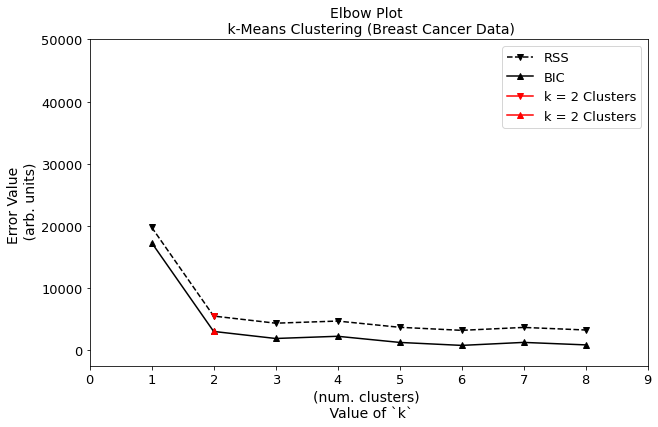

In [4]:
plot_clusters(k_value=8, 
              m_features=num_feat_bc, 
              n_points=num_points_bc, 
              data=data_bc, data_string="Breast Cancer Data", highlight=1)

In [5]:
elbow_data_bc = [func(n_clusters=each, 
                        m_features=num_feat_bc, 
                        n_points=num_points_bc, 
                        data=data_bc) for each in range(1, 8+1)]
elbow_data_bc

[{'n_clusters': 1,
  'sum_square_error_J': 19768.844062947064,
  'bic': 19781.64421023792},
 {'n_clusters': 2,
  'sum_square_error_J': 5472.711193824097,
  'bic': 5498.311488405808},
 {'n_clusters': 3,
  'sum_square_error_J': 4325.917462786623,
  'bic': 4364.3179046591895},
 {'n_clusters': 4,
  'sum_square_error_J': 4668.471257180348,
  'bic': 4719.671846343771},
 {'n_clusters': 5,
  'sum_square_error_J': 3666.335660580021,
  'bic': 3730.336397034299},
 {'n_clusters': 6,
  'sum_square_error_J': 3175.6694592406448,
  'bic': 3252.470342985778},
 {'n_clusters': 7,
  'sum_square_error_J': 3645.0486270187375,
  'bic': 3734.6496580547264},
 {'n_clusters': 8,
  'sum_square_error_J': 3230.890514031203,
  'bic': 3333.291692358048}]

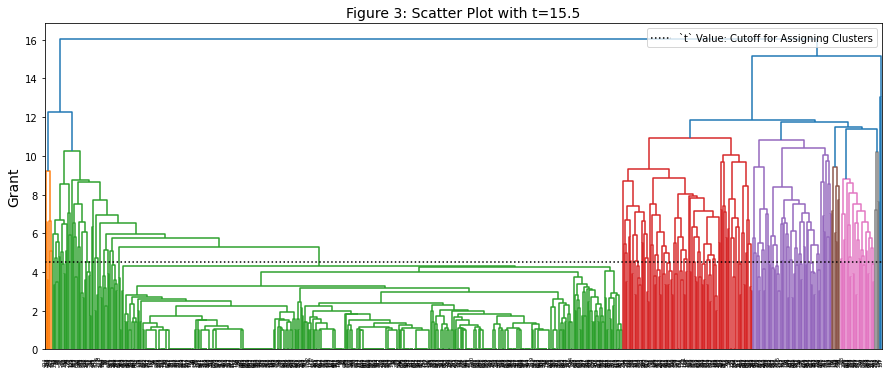

In [6]:
plt.figure(figsize=(15, 6))
plt.axhline(y=4.5, color='black', linestyle='dotted', label='`t` Value: Cutoff for Assigning Clusters')
clf = linkage(data_bc, method='average', metric='euclidean')
string = 'Figure ' + str(3) + ': Scatter Plot with ' + 't=' + str(15.5)
plt.title(string, fontsize=14)
plt.legend()
plt.ylabel("Grant", fontsize=14)
dendrogram(clf)
plt.show()

In [7]:
y_pred_class = fcluster(clf, t=15.5, criterion='distance')

In [8]:
set(list(y_pred_class))

{1, 2}

In [9]:
def create_clusters_gmm(num_clusters=None, data=None):
    clf = GaussianMixture(n_components=num_clusters, random_state=42).fit(data)
    plt.figure(figsize=(10, 6))
    
    plt.scatter(data[:,0], data[:,1], c=clf.predict(data).astype(float))
    plt.scatter(x=list(clf.means_[:,0]), 
                y=list(clf.means_[:,1]), 
                c='r', s=50, marker='X')
    
    plt.xlabel('X-Values', fontsize=14)
    plt.ylabel('Y-Values', fontsize=14)
    string = 'Figure ' + str(2) + ': Scatter Plot with ' + str(num_clusters) + ' Cluster Centroids (GMM)'
    
    plt.title(string, fontsize=14)
    plt.show()

In [10]:
clf = GaussianMixture(n_components=2, random_state=42).fit(data_bc)
set(list(clf.predict(data_bc)))

{0, 1}

In [11]:
km_ = KMeans(n_clusters=2, random_state=42).fit(data_bc)
gmm_ = GaussianMixture(n_components=2, random_state=42).fit(data_bc)

In [12]:
km_y_pred_class = km_.predict(data_bc)
gmm_y_pred_class = gmm_.predict(data_bc)

In [13]:
# Compare k-Means and GMM using the criteria in the homework assignment.

data_bc_gt_label_transform = []
for each in data_bc_gt_label:
    
    if each == 4:
        data_bc_gt_label_transform.append(0)
        
    else: 
        data_bc_gt_label_transform.append(1)
        
data_bc_gt_label_transform_array = np.array(data_bc_gt_label_transform)

total_samples = len(data_bc_gt_label)

cm_km = confusion_matrix(data_bc_gt_label_transform_array, km_y_pred_class)
cm_gmm = confusion_matrix(data_bc_gt_label_transform_array, gmm_y_pred_class)

In [14]:
cm_km

array([[223,  18],
       [ 11, 447]])

In [15]:
cm_gmm

array([[  0, 241],
       [370,  88]])

In [16]:
P_km = cm_km[0][0] / total_samples
P_gmm = cm_gmm[0][0] / total_samples

In [17]:
print('P_km: {}, P_gmm: {}'.format(P_km, P_gmm))

P_km: 0.3190271816881259, P_gmm: 0.0


In [18]:
silhouette_avg_km = silhouette_score(data_bc, km_y_pred_class)
silhouette_avg_gmm = silhouette_score(data_bc, gmm_y_pred_class)

In [19]:
print('silhouette_avg_km: {:.4f} silhouette_avg_gmm: {:.4f}'.format(silhouette_avg_km, 
                                                                    silhouette_avg_gmm))

silhouette_avg_km: 0.5960 silhouette_avg_gmm: 0.4204
